In [52]:
# import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as skio
import scipy
import rle
import zstd
import pickle
from skimage.util import view_as_blocks
from skimage.color import rgb2ycbcr, ycbcr2rgb
import codec

import importlib
importlib.reload(codec)

<module 'codec' from '/Users/terryluongo/Documents/GitHub/cs452/compression/codec.py'>

# JPEG Algo

Image shape: (352, 800, 3)
Image data type: uint8
Theoretical uncompressed image size: 0.81 MB


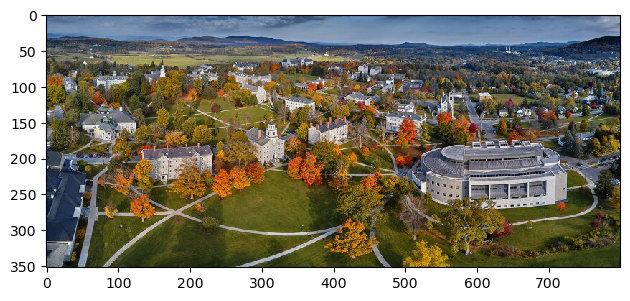

In [3]:
img = skio.imread("midd.jpeg")
img = img[1:,  ] # should standardize this to blocks
skio.imshow(img)

print(f'Image shape: {img.shape}')
print(f'Image data type: {img.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(img.shape)) / (1024 ** 2),2)} MB')

In [1]:
class JPEG:
    def __init__(self, img_array, q, block_size = 8, downsample_ratio = "4:2:0"):
        self.img_array = img_array
        self.block_size = block_size
        self.downsample_ratio = downsample_ratio
        self.q_array = None
        self.q = q
        self.Y = None
        self.Cb = None
        self.Cr = None


    # makes/displays img array
    def show_image(self):
        plt.imshow(self.img_array)


    
    # saves to binary, compresses
    def save_image(self, filename):
        pickled_data = pickle.dumps(self)
        compressed_data = zstd.compress(pickled_data)
        with open(filename, 'wb') as f:
            f.write(compressed_data)


    
    def load_image(filename):
        with open(filename, 'rb') as f:
            compressed = f.read()
    
        decompressed = zstd.decompress(compressed)
        data = pickle.loads(decompressed)

        return data


    
    def compare_image(self, img):
        fig, axs = plt.subplots(1, 2)
        fig.set_figheight(12)
        fig.set_figwidth(15)
        
        axs[0].imshow(img)
        axs[0].set_title("Original")
        
        axs[1].imshow(self.img_array)
        axs[1].set_title("Reconstruction")


    
    def compare_slice(self, img, start = 50, end = 75):
        fig, axs = plt.subplots(1, 2)
        fig.set_figheight(12)
        fig.set_figwidth(15)
        
        axs[0].imshow(img[start:end, start:end])
        axs[0].set_title("Original")
        
        axs[1].imshow(self.img_array[start:end, start:end])
        axs[1].set_title("Reconstruction")


    
    def print_block(self,block_x = 25, block_y = 25, channel = "Y"):
        print(self.__dict__[channel][block_y, block_x])


    
    # ripped this straight from Claude...
    # we can batch apply our functions now, channel wise (less for loops in function)
    def process_channels(self, function, **kwargs):
        channels = [self.Y, self.Cb, self.Cr]
        processed_channels = []

        for i, channel in enumerate(channels):
            processed_channel = function(channel, **kwargs, index = i) # need to pass through all the stuff we might need
            processed_channels.append(processed_channel)

        self.Y, self.Cb, self.Cr = processed_channels


    
    # 1. rgb_2_ycbcr, 2. downsampling, 3. blocking, 4. DCT, 5. quantizing, 6. zigzagging
    def encode(self, max_step = 6):
        
        self.Y, self.Cb, self.Cr = codec.rgb_to_YCbCr(self.img_array)

        if max_step == 1:
            return
        
        functions = [codec.downscale_colors, codec.form_blocks, codec.calculate_blocked_dct, codec.quantize, codec.zigzag]
        kwargs = {"block_size": self.block_size, "q": self.q, "downsample_ratio": self.downsample_ratio}
        
        for f in functions[: max_step - 1]:
            self.process_channels(f, **kwargs)

    
    
    def decode(self, from_step = 6):

        functions = [codec.rescale_colors, codec.reconstruct_blocks, codec.inverse_block_dct, codec.dequantize, codec.unzigzag]
        kwargs = {"block_size": self.block_size, "q": self.q, "downsample_ratio": self.downsample_ratio}
        
        while from_step > 1:
            self.process_channels(functions[from_step - 2], **kwargs)
            from_step -= 1

        self.img_array = codec.YCbCr_to_rgb([self.Y, self.Cb, self.Cr])


    
    # use these to I only pickle what is necessary.  otherwise it wouldn't save space at all
    def __getstate__(self):
        # Return a dictionary containing only the attributes you want to pickle
        return {'q': self.q, 'block_size': self.block_size, 
                'downsample_ratio': self.downsample_ratio, 
                'Y': self.Y, 'Cb': self.Cb, 'Cr': self.Cr}


    
    def __setstate__(self, state):
        # Restore the unpickled state
        self.q = state['q']
        self.block_size = state['block_size']
        self.downsample_ratio = state['downsample_ratio']
        self.Y = state['Y']
        self.Cb = state['Cb']
        self.Cr = state['Cr']
        self.img_array = None

## All the Way to Zigzagging

Here is the comparison between the original and our encoding.

35.86729340107652
234.8041882352941
18.327714868709517
164.23482352941176
12.161721728247072
210.97668235294117
35.86729340107652
234.8041882352941
17.969768876678827
164.23482352941176
11.909810927569048
210.97668235294117
-73.3760588235294
218.8041882352941
228
255


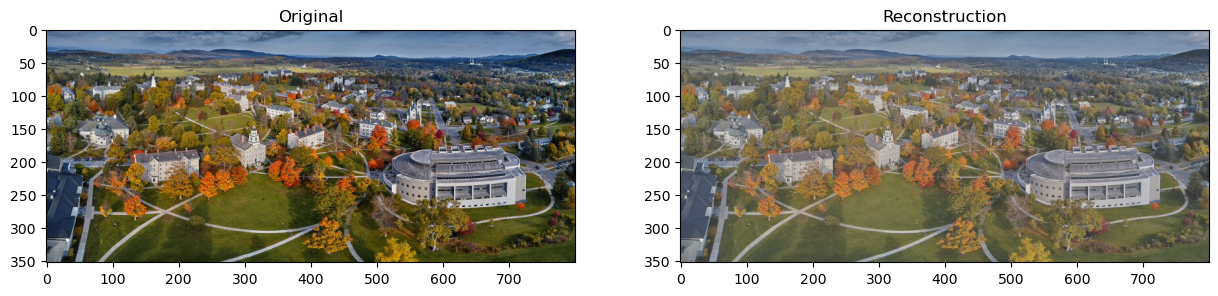

In [53]:
jpg = JPEG(img, downsample_ratio="4:2:0", q = 80)
jpg.encode(max_step=2)
jpg.decode(from_step=2)
jpg.compare_image(img)

print(jpg.img_array[:, :, 1].max()) # caused from downsampling, very strangely
print(img[:, :, 1].max())
# when outputting uint8 after quantization, can really fuck shit up

# most suspect about downsampling and quantization.  check types for quantization, no clue for downsampling

## Actually saving to disk

Here we save to disk, load that filepath, decode.  As you can see it looks the same compared to above because all of the lossy steps happened already.  For this image here our JPEG achieves 300 kB vs 800 kB for original, but 100 kB for how the computer does the JPEG.

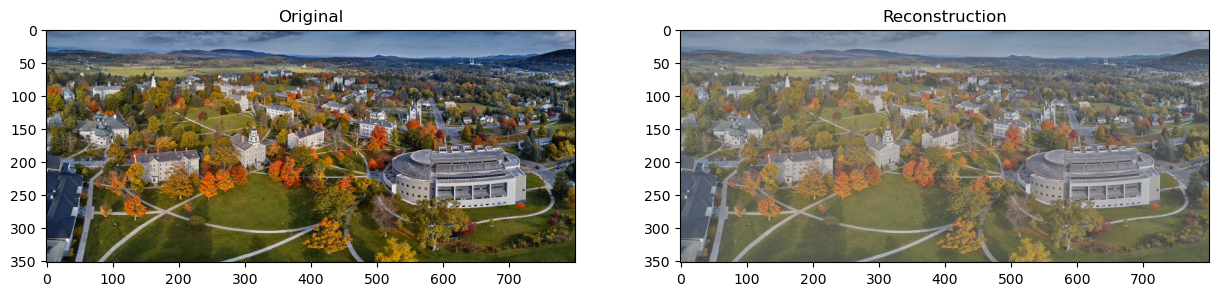

In [18]:
jpg = JPEG(img, downsample_ratio="4:2:0", q = 80)
jpg.encode()
jpg.save_image("1.zst")
jpg2 = JPEG.load_image("1.zst")
jpg2.decode()
jpg2.compare_image(img)


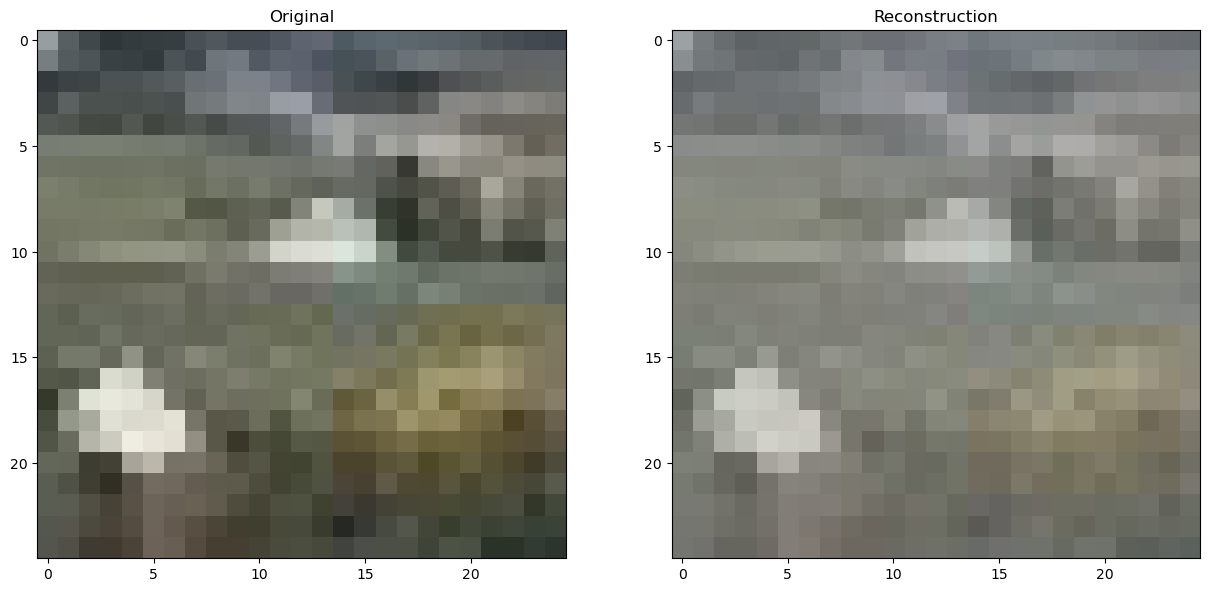

In [10]:
jpg.compare_slice(img)

In [14]:
# investigating quantization
jpg = JPEG(img, downsample_ratio="4:2:0", q = 80)
jpg.encode(max_step = 3)
jpg.print_block(5,5,channel = "Cr")

print(img[5*8,5*8,1

[[125.51821176 125.58963922 126.08963137 126.07898039 127.4680549
  128.13220392 127.91792157 128.        ]
 [127.19299608 127.33585098 127.3252     127.24312157 127.24312157
  127.4680549  127.98934902 128.1428549 ]
 [128.72492549 128.79635294 128.13220392 127.90727059 127.90727059
  127.3252     127.47870588 127.19299608]
 [128.80700392 128.58207059 128.58207059 127.91792157 127.33585098
  127.19299608 126.0288549  126.32521569]
 [128.01065098 128.01065098 128.01065098 127.20364706 126.18236078
  126.03950588 125.45743529 125.38600784]
 [126.26443922 126.26443922 126.26443922 125.45743529 125.45743529
  125.45743529 125.38600784 125.38600784]
 [123.54706667 123.40421176 123.40421176 124.21121569 124.35407059
  124.35407059 125.37535686 125.51821176]
 [121.63669804 121.86163137 122.74006275 123.68992157 123.68992157
  124.27199216 125.58963922 125.36470588]]
